In [3]:
# import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# import seaborn as sns
import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from tensorflow_addons.metrics import RSquare

import findspark
# Start Spark Session
findspark.init('C:\Spark\spark-3.2.2-bin-hadoop2.7')
import pyspark
from pyspark import SparkFiles
from pyspark.sql.functions import to_date, to_timestamp
from getpass import getpass


# Build Spark Session
### IMPORTANT: MAKE SURE THAT spark.config has memory set to 32GB or larger!
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Qwest-Analytics-Dashboard-and-ML-Model").config("spark.jars", "C:\Spark\spark-3.2.2-bin-hadoop2.7\jars\postgresql-42.5.1.jar").getOrCreate()

#Store environmental variables
password = getpass('Enter DataBase Password: ')

#Configure for RDS
jdbc_url="jdbc:postgresql://qwest-final-project.ccngkdwtiuvz.us-east-2.rds.amazonaws.com:5432/Qwest-Database"
config = {"user":"postgres", 
          "password": password, 
          "driver":"org.postgresql.Driver"}

In [4]:
# Load the minute aggregation data

minute_aggregation_data_df = spark.read.format("jdbc").options(
         url='jdbc:postgresql://qwest-final-project.ccngkdwtiuvz.us-east-2.rds.amazonaws.com:5432/Qwest-Database',
         dbtable='cleaned_merged_minute_aggregation',
         user='postgres',
         password=password,
         driver='org.postgresql.Driver').load()

minute_aggregation_data_df.show()
minute_aggregation_data_df.printSchema()

+-------------------+--------------+--------------+------------------------------+--------+-----------+------------------+--------------------+-------------+
|               time|       country|total_sessions|total_session_duration_seconds|operator|    channel|cleaned_content_id|               genre|       region|
+-------------------+--------------+--------------+------------------------------+--------+-----------+------------------+--------------------+-------------+
|2022-02-19 08:07:00| United States|           2.0|                         120.0|  Op_006|Channel_002|          PRO_1334|ORCHESTRA, CLASSICAL|North America|
|2022-02-19 08:07:00|       Finland|           1.0|                          60.0|  Op_006|Channel_002|          PRO_1334|ORCHESTRA, CLASSICAL|       Europe|
|2022-02-19 08:07:00|United Kingdom|           1.0|                          60.0|  Op_006|Channel_002|          PRO_1334|ORCHESTRA, CLASSICAL|       Europe|
|2022-02-19 08:08:00|       Finland|           1.0| 

In [5]:
# put cleaned minute aggregation data in as PANDAS dataframe, as well as country to filter and start/end datetime in YYYY-MM-DD HH:mm:ss format
def min_agg_trimmer(df, country, resample_by, start_datetime, end_datetime):
    # Change string to datetime
    df['time'] = pd.to_datetime(df['time'])
    # drop extra index column
    # df = df.drop(columns=df.columns[0], axis=1) (THIS WAS FOR LEGACY DATASET)
    # loc to timeframe of advertising data
    # Max supported for merging with advertising data is:
    #df = df.loc[(df['time'] >= '2022-01-01 00:00:00') & (df['time'] <='2022-10-25 23:59:59')]
    df = df.loc[(df['time'] >= start_datetime) & (df['time'] <= end_datetime)]
    # drop columns
    df = df.drop(['operator', 'channel', 'cleaned_content_id'], axis=1)
    # filter by country
    df = df.loc[(df['country'] == country)]
    # remove space after comma for some genre entries for get dummies seperator
    df['genre'] = df['genre'].str.replace(r'([ ]+,[ ]+)',",")
    df['genre'] = df['genre'].str.strip()
    # split genres with get dummies and drop genre column.  Clean data strip spaces from genre column names
    df = pd.concat([df,df.genre.str.get_dummies(sep=',')],1)
    df = df.drop('genre', axis=1)
    df.columns = df.columns.str.strip()
    # check column names
    print(df.columns.values.tolist())
    # filter by date and resample
    df = df.loc[(df['time'] >= start_datetime) & (df['time'] <=end_datetime)]
    df = df.resample(resample_by, on='time').sum().reset_index()
    df = df.sort_values(['time'])
    return df

In [6]:
# Can the ML model predict viewership based on genre? What happens if we add datetime?
# lets try for UK
uk_data = min_agg_trimmer(minute_aggregation_data_df.toPandas(), 'United Kingdom', 'H', '2022-01-01 00:00:00','2022-10-25 23:59:59')
uk_data

C:\Spark\spark-3.2.2-bin-hadoop2.7\python\pyspark\sql\pandas\conversion.py:194: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)
C:\Users\Peter Nguyen\AppData\Local\Temp\ipykernel_11996\1999615133.py:16: FutureWarning: The default value of regex will change from True to False in a future version.
  df['genre'] = df['genre'].str.replace(r'([ ]+,[ ]+)',",")
C:\Users\Peter Nguyen\AppData\Local\Temp\ipykernel_11996\1999615133.py:19: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  df = pd.concat([df,df.genre.str.get_dummies(sep=',')],1)


['time', 'country', 'total_sessions', 'total_session_duration_seconds', 'region', '20TH CENTURY', 'ACID TECHNO', 'ACID-JAZZ', 'AFRO DANCE', 'AFRO HOUSE', 'AFRO-CUBAN JAZZ', 'AFRO-POP / AFROBEATS', 'AFROBEAT', 'ALTERNATIVE', 'ALTERNATIVE HIP-HOP', 'AMBIENT', 'ARABIC MUSIC', 'AVANT-GARDE JAZZ', 'BALLET', 'BAROQUE', 'BEBOP', 'BIG BAND', 'BLUE-EYED SOUL / A.O.R.', 'BLUES', 'BLUES ROCK', 'BOOGIE-FUNK', 'BOSSA NOVA', 'BOSSA-JAZZ', 'BOUNCE MUSIC', 'BRASS BAND', 'BREAKDANCE', 'BROKEN BEAT', 'CARIBBEAN MUSIC', 'CENTRAL AFRICAN MUSIC', 'CHAMBER MUSIC', 'CHAÂBI', 'CHICAGO BLUES', 'CLASSICAL', 'CLASSICAL CROSSOVER', 'CONCERTO', 'CONSCIOUS HIP HOP', 'CONTEMPORARY', 'CONTEMPORARY DANCE', 'CONTEMPORARY JAZZ', 'COOL JAZZ / WEST COAST JAZZ', 'COUNTRY BLUES', 'CROSSOVER JAZZ', 'DANCE', 'DARK AMBIENT', 'DARK TECHNO', 'DEEP HOUSE', 'DETROIT TECHNO', 'DIRTY SOUTH RAP', 'DISCO', 'DISCO HOUSE', 'DOWNTEMPO / CHILL OUT', 'DUBTRONICA', 'EAST COAST RAP', 'ELECTRO', 'ELECTRO HOUSE', 'ELECTRO JAZZ / NU-JAZZ', 'ELE

C:\Users\Peter Nguyen\AppData\Local\Temp\ipykernel_11996\1999615133.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.resample(resample_by, on='time').sum().reset_index()


,time,total_sessions,total_session_duration_seconds,20TH CENTURY,ACID TECHNO,ACID-JAZZ,AFRO DANCE,AFRO HOUSE,AFRO-CUBAN JAZZ,AFRO-POP / AFROBEATS,...,TOUAREG MUSIC,TRANCE,TRAP,TRIP HOP,TROPICAL HOUSE,TURKISH FOLK MUSIC,VOCAL JAZZ,WEST AFRICAN MUSIC,WEST COAST RAP,ZOUK
0,2022-01-01 00:00:00,1048.0,51424.0,40,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2022-01-01 01:00:00,694.0,33579.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2022-01-01 02:00:00,539.0,26358.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2022-01-01 03:00:00,386.0,19161.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2022-01-01 04:00:00,105.0,4855.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7147,2022-10-25 19:00:00,3550.0,180250.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7148,2022-10-25 20:00:00,3380.0,167974.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,65,0,0
7149,2022-10-25 21:00:00,3269.0,166947.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,191,0,0
7150,2022-10-25 22:00:00,2579.0,133429.0,0,0,0,0,0,0,0,...,0,0,0,81,0,0,0,0,0,0


In [7]:
# drop rows where data is empty
uk_data = uk_data[uk_data['total_sessions'] != 0]
uk_data = uk_data.drop('total_sessions', axis=1)
#uk_data = uk_data.drop('time')

Build the ML Model

In [23]:
# Split our preprocessed data into our features and target arrays

# ----------- FOR SEQUENTIAL MODEL ------------------------------------------
# y = uk_data["total_session_duration_seconds"].values
# X = uk_data.drop(["total_session_duration_seconds"],1).values

# # Split the preprocessed data into a training and testing dataset
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=69)
#----------------------------------------------------------------------------

#------------ FOR TIME SERIES MODEL -----------------------------------------
split_fraction = 0.7
train_split = int(split_fraction * int(uk_data.shape[0]))

# can optimize these parameters later...
learning_rate = 0.01
batch_size = 256
epochs = 1000

# configure test and training split
#feature_list = uk_data.columns.to_list()
#feature_list.remove('time')
#feature_list.remove('country')
#feature_list.remove('total_session_duration_seconds')
#feature_list.remove('region')
def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

date_time_key = 'time'
features = uk_data.drop(['time', 'total_session_duration_seconds'], axis=1)
features.index=uk_data[date_time_key]
features.index = pd.to_datetime(features.index)

features = normalize(features.values, train_split)
features = pd.DataFrame(features)
features.head()

train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]


#----------------------------------------------------------------------------

C:\Users\Peter Nguyen\AppData\Local\Temp\ipykernel_11996\1821749822.py:29: RuntimeWarning: divide by zero encountered in divide
  return (data - data_mean) / data_std
C:\Users\Peter Nguyen\AppData\Local\Temp\ipykernel_11996\1821749822.py:29: RuntimeWarning: invalid value encountered in divide
  return (data - data_mean) / data_std


In [24]:
#------------ FOR TIME SERIES MODEL -----------------------------------------
# prediction timeframe / observation timeframe ie: 1 hour / 10 minutes = 6
step = 24
# number of past timestamps used to train ie if 1 hour and 10 minute observation split, look back 120 hours is 120*6=720 or historic model timeframe * step
past = 7*step
# number of future timestamps to predict ie if we want to predict 12 hours into the future, 12*6=72 or future model timeframe * step
future = 1*step

start = past + future
end = start + train_split

X_train = train_data[[i for i in range(7)]].values
y_train = features.iloc[start:end][[1]]

sequence_length = int(past / step)
#----------------------------------------------------------------------------

# ----------- FOR SEQUENTIAL MODEL ------------------------------------------
# # Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
# input_features = len(X_train[0])
# hidden_nodes_layer1 = 180
# hidden_nodes_layer2 = 50
# hidden_nodes_layer3 = 10

# neural_network = tf.keras.models.Sequential()

# # First hidden layer
# neural_network.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=input_features, activation="relu"))
# # Second hidden layer
# neural_network.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))
# # third hidden layer
# neural_network.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="relu"))

# # Output layer
# neural_network.add(tf.keras.layers.Dense(units=1))

# # Check the structure of the model
# neural_network.summary()
# # Compile Model
# neural_network.compile(loss= "mean_squared_error" , optimizer="adam", metrics=[RSquare()])

#----------------------------------------------------------------------------

#------------ FOR TIME SERIES MODEL -----------------------------------------
# PreProcessing
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    X_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

x_end = len(val_data) - past - future

label_start = train_split + past + future

x_val = val_data.iloc[:x_end][[i for i in range(7)]].values
y_val = features.iloc[label_start:][[1]]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

# Training 
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out1 = keras.layers.LSTM(64)(inputs)
outputs = keras.layers.Dense(1)(lstm_out1)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse", metrics=['accuracy'])
model.summary()
#----------------------------------------------------------------------------

Input shape: (256, 7, 7)
Target shape: (256, 1)
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 7, 7)]            0         
                                                                 
 lstm_8 (LSTM)               (None, 64)                18432     
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 18,497
Trainable params: 18,497
Non-trainable params: 0
_________________________________________________________________


In [25]:
# ----------- FOR SEQUENTIAL MODEL ------------------------------------------
# fit model
#neural_network.fit(X_train, y_train, epochs=500)
#----------------------------------------------------------------------------

# path_checkpoint = "model_checkpoint.h5"
#es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

# modelckpt_callback = keras.callbacks.ModelCheckpoint(
#     monitor="val_loss",
#     filepath=path_checkpoint,
#     verbose=1,
#     save_weights_only=True,
#     save_best_only=True,
# )

#------------ FOR TIME SERIES MODEL -----------------------------------------
history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
#    callbacks=[es_callback, modelckpt_callback],
)
#----------------------------------------------------------------------------

Epoch 1/1000
14/14 [==============================] - 3s 61ms/step - loss: 1.0760 - accuracy: 0.0000e+00 - val_loss: 2.7725 - val_accuracy: 0.0000e+00
Epoch 2/1000
14/14 [==============================] - 0s 19ms/step - loss: 1.0678 - accuracy: 0.0000e+00 - val_loss: 2.6974 - val_accuracy: 0.0000e+00
Epoch 3/1000
14/14 [==============================] - 0s 19ms/step - loss: 1.0444 - accuracy: 0.0000e+00 - val_loss: 2.7122 - val_accuracy: 0.0000e+00
Epoch 4/1000
14/14 [==============================] - 0s 19ms/step - loss: 1.0391 - accuracy: 0.0000e+00 - val_loss: 2.7139 - val_accuracy: 0.0000e+00
Epoch 5/1000
14/14 [==============================] - 0s 19ms/step - loss: 1.0325 - accuracy: 0.0000e+00 - val_loss: 2.7180 - val_accuracy: 0.0000e+00
Epoch 6/1000
14/14 [==============================] - 0s 19ms/step - loss: 1.0256 - accuracy: 0.0000e+00 - val_loss: 2.7263 - val_accuracy: 0.0000e+00
Epoch 7/1000
14/14 [==============================] - 0s 19ms/step - loss: 1.0159 - accuracy: 

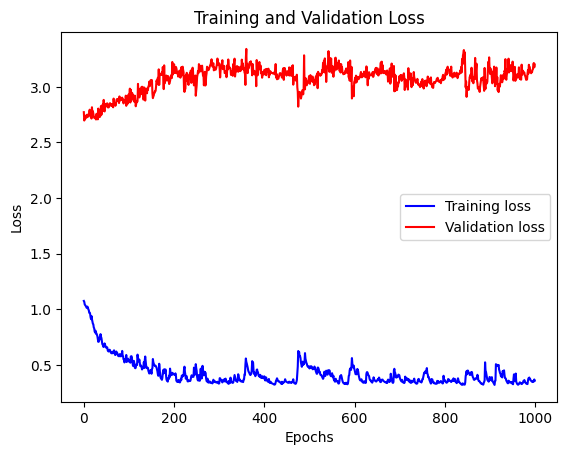

8/8 [==============================] - 0s 2ms/step


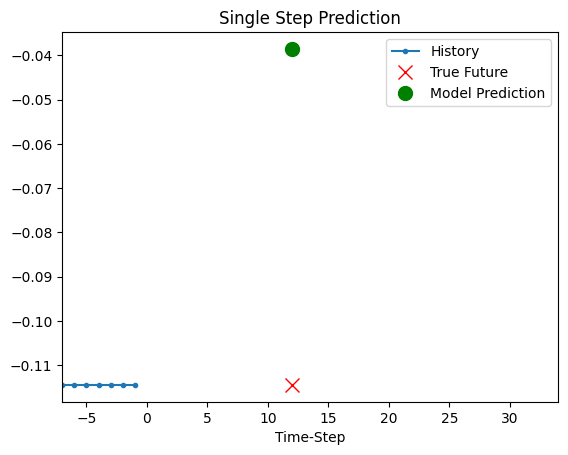

8/8 [==============================] - 0s 2ms/step


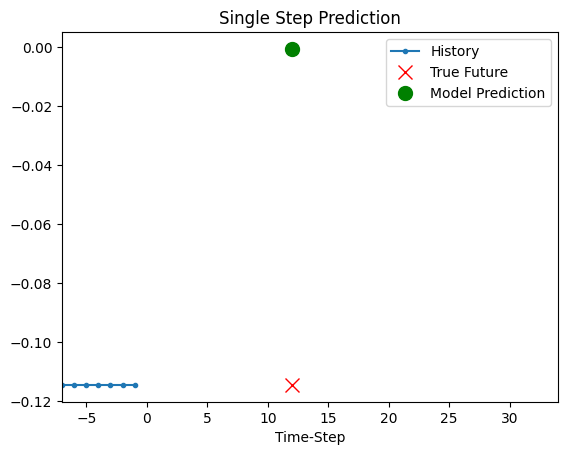

8/8 [==============================] - 0s 2ms/step


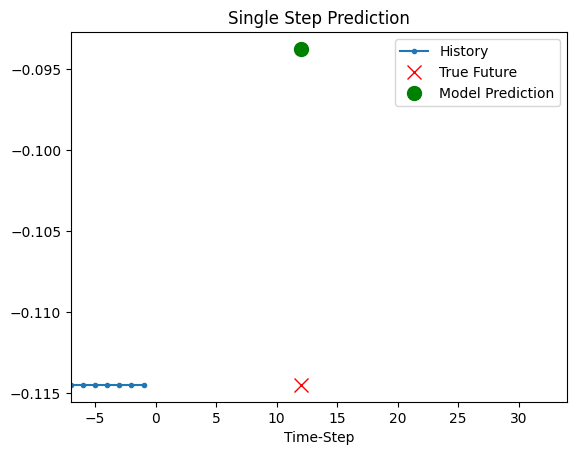

8/8 [==============================] - 0s 2ms/step


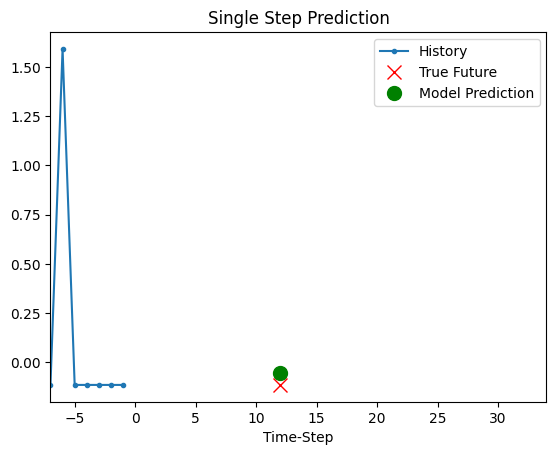

5/5 [==============================] - 0s 2ms/step


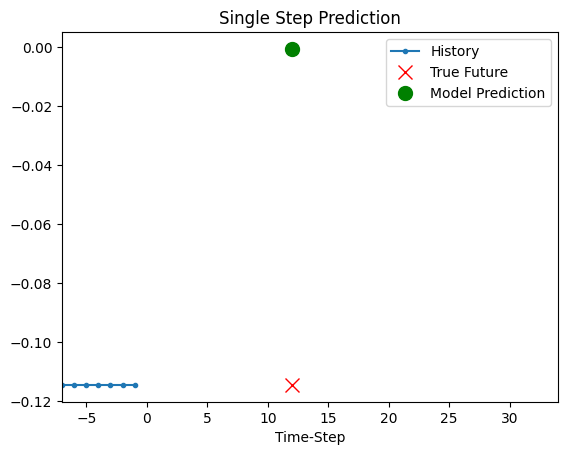

In [26]:
# ----------- FOR SEQUENTIAL MODEL ------------------------------------------
#check results
# y_test_pred = neural_network.predict(X_test)
# plt.plot(y_test)
# plt.plot(y_test_pred)
#----------------------------------------------------------------------------

#------------ FOR TIME SERIES MODEL -----------------------------------------
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    )
#----------------------------------------------------------------------------